# 必要なライブラリの準備

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from time import time
from copy import deepcopy

import numpy as np
import pandas as pd
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

import pickle
import json

from winsound import Beep

import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

# ハイパーパラメータ・活性化関数・最適化アルゴリズムの定義

In [2]:
hyperparam_dict = {

    'API_type' : 307,
    'hidden1_dim' : 32,
    'n_classes' : 1,

    'bias1' : True,
    'bias2' : True,

    'dropout1_rate' : 0.5,

    'epoch' : 1000,
    'loss_func' : nn.BCEWithLogitsLoss(),

    'optimizer' : {
        'algorithm' : optim.Adam,
        'param' : {
            'lr' : 5e-4,
            'weight_decay' : 1e-2,
        }
    },

    'batch_size' : 32,
    'n_splits' : 10,

    'data_random_state' : 0,
    'fold_random_state' : 0,
    'weight_random_state' : 0,

    'device' : torch.device('cuda'),

}

# データセットの作成

In [3]:
df = pd.read_csv('./dynamic_api_call_sequence_per_malware_100_0_306.csv')
df

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43871,e3d6d58faa040f0f9742c9d0eaf58be4,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,260,141,1
43872,9b917bab7f32188ae40c744f2be9aaf8,82,240,117,240,117,240,117,240,117,...,159,224,82,159,224,82,159,224,82,1
43873,35a18ee05f75f04912018d9f462cb990,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,260,1
43874,654139d715abcf7ecdddbef5a84f224b,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,260,141,1


In [4]:
X = df.drop(['hash', 'malware'], axis = 1).values.astype(int)
y = df['malware'].values.astype(float)
del df
print(X.shape)
print(y.shape)

(43876, 100)
(43876,)


In [5]:
def check_imbalance(dataset):
    count = sorted(Counter(dataset).items())
    print(count)
    print(count[1][1] / count[0][1])
    return

random_undersampler = RandomUnderSampler(random_state = hyperparam_dict['data_random_state'])
X, y = random_undersampler.fit_resample(X, y)
check_imbalance(y)

dataset = list(zip(X, y))

[(0.0, 1079), (1.0, 1079)]
1.0


In [6]:
fold = KFold(n_splits = hyperparam_dict['n_splits'],
             shuffle = True,
             random_state = hyperparam_dict['fold_random_state'])

# モデルの定義

In [7]:
class RNN_network(nn.Module):
    
    def __init__(self, input_dim, hidden1_dim, n_classes, dropout1_rate, bias1=True, bias2=True):
        
        super(RNN_network, self).__init__()
        
        self.input_dim = input_dim
        self.hidden1_dim = hidden1_dim
        self.dropout1_rate = dropout1_rate
        
        self.rnn1 = nn.RNN(self.input_dim, self.hidden1_dim, batch_first = True, bias = bias1)
        self.dropout1 = nn.Dropout(p = self.dropout1_rate)
        self.fc = nn.Linear(self.hidden1_dim, n_classes, bias = bias2)
        
    def forward(self, X):
        
        X = F.one_hot(X, num_classes = self.input_dim).float().cuda()
        
        # Hidden layer shape: (num_layers, batch_size, hidden_dim)
        hidden_0 = torch.zeros(1, X.size(0), self.hidden1_dim).float().cuda()
        
        # Input/Output shape: (batch_size, seq_len, input_dim)
        _, self.hidden1 = self.rnn1(X, hidden_0)
                
        H = self.hidden1[0].squeeze()
        H = self.dropout1(H)
        H = self.fc(H)
                
        return H.squeeze()

# 評価値の定義

In [8]:
def evaluate(loader, model, metric_dict):

    sum_loss = 0.0
    all_dataset = len(loader.dataset)
    all_output = torch.tensor([]).to(hyperparam_dict['device'])
    all_label = torch.tensor([]).to(hyperparam_dict['device'])

    for batch_data, batch_label in loader:
        batch_data, batch_label = batch_data.long().to(hyperparam_dict['device']), batch_label.to(hyperparam_dict['device'])
        batch_output = model(batch_data)
        batch_loss = loss_func(batch_output, batch_label)
        optimizer.zero_grad()

        sum_loss += batch_loss.detach().item() * batch_output.shape[0]
        all_output = torch.cat((all_output, batch_output))
        all_label = torch.cat((all_label, batch_label))

    sigmoid = nn.Sigmoid()
    all_pred, all_score, all_label = (all_output >= 0).cpu(), sigmoid(all_output).cpu(), all_label.cpu()
    tn, fp, fn, tp = confusion_matrix(all_label, all_pred).flatten()

    metric_dict['Loss'][-1].append(sum_loss / all_dataset)
    metric_dict['Accuracy'][-1].append(accuracy_score(all_label, all_pred))
    metric_dict['Precision'][-1].append(precision_score(all_label, all_pred))
    metric_dict['Recall'][-1].append(recall_score(all_label, all_pred))
    metric_dict['F1-Score'][-1].append(f1_score(all_label, all_pred))
    metric_dict['ROC-Curve'][-1].append(roc_curve(all_label, all_score))
    metric_dict['AUC'][-1].append(roc_auc_score(all_label, all_pred))
    metric_dict['TP'][-1].append(tp)
    metric_dict['FP'][-1].append(fp)
    metric_dict['TN'][-1].append(tn)
    metric_dict['FN'][-1].append(fn)

# 学習と評価

In [9]:
metric_dict = {
    'Loss' : [],
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1-Score' : [],
    'ROC-Curve' : [],
    'AUC': [],
    'TP' : [],
    'TN' : [],
    'FP' : [],
    'FN' : [],
}

eval_dict = {
    'Train' : deepcopy(metric_dict),
    'Test' : deepcopy(metric_dict),
    'Time' : {
        'Train_Time' : [],
        'Eval_Time' : [],
    },
}

loss_func = hyperparam_dict['loss_func']

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(dataset)):
    
    print(f'Fold {fold_idx}')

    torch.manual_seed(hyperparam_dict['weight_random_state'])

    model = RNN_network(
        input_dim = hyperparam_dict['API_type'],
        hidden1_dim = hyperparam_dict['hidden1_dim'],
        n_classes = hyperparam_dict['n_classes'],
        dropout1_rate = hyperparam_dict['dropout1_rate'],
        bias1 = hyperparam_dict['bias1'],
        bias2 = hyperparam_dict['bias2'],
        ).to(hyperparam_dict['device'])

    optimizer = hyperparam_dict['optimizer']['algorithm'](
        params = model.parameters(),
        lr = hyperparam_dict['optimizer']['param']['lr'],
        weight_decay = hyperparam_dict['optimizer']['param']['weight_decay']
        )
    
    temp_optim = {key : optimizer.param_groups[0][key] for key in optimizer.param_groups[0] if key != 'params'}
    temp_optim['betas'] = list(temp_optim['betas'])
    hyperparam_dict['optimizer']['param'] = temp_optim

    for i, param in enumerate(model.parameters()):
        print(f'\nparam {i}')
        print(param.shape)
        print(param)
    print(f'\nParameters: {np.sum([param.numel() for param in model.parameters()])}\n')
    
    train_loader = DataLoader(
        Subset(dataset, train_idx),
        shuffle = True,
        batch_size = hyperparam_dict['batch_size'],
        )
    
    test_loader = DataLoader(
        Subset(dataset, test_idx),
        shuffle = False,
        batch_size = hyperparam_dict['batch_size'],
        )

    [eval_dict['Train'][key].append([]) for key in eval_dict['Train']]
    [eval_dict['Test'][key].append([]) for key in eval_dict['Test']]
    eval_dict['Time']['Train_Time'].append([])
    eval_dict['Time']['Eval_Time'].append([])

    for epoch in range(hyperparam_dict['epoch']):
        
        # Training
        start_train_time = time()
        model.train()
        for batch_data, batch_label in train_loader:
            batch_data, batch_label = batch_data.long().to(hyperparam_dict['device']), batch_label.to(hyperparam_dict['device'])
            output = model(batch_data)
            loss = loss_func(output, batch_label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()       
        eval_dict['Time']['Train_Time'][-1].append(time() - start_train_time)

        # Evaluation
        start_eval_time = time()
        model.eval()
        with torch.no_grad():

            # Trainset
            evaluate(
                loader = train_loader,
                model = model,
                metric_dict = eval_dict['Train'],
                )

            # Testset
            evaluate(
                loader = test_loader,
                model = model,
                metric_dict = eval_dict['Test'],
            )
        eval_dict['Time']['Eval_Time'][-1].append(time() - start_eval_time)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}')
            for key, value in eval_dict.items():
                print(f'\n\t{key}')
                for metric in value:
                    if metric != 'ROC-Curve':
                        print(f'\t\t{metric} : {value[metric][-1][-1]}')
            print()

    torch.save(model.state_dict(), 'param{}.pth'.format(fold_idx))

Fold 0

param 0
torch.Size([32, 307])
Parameter containing:
tensor([[-0.0013,  0.0948, -0.1455,  ...,  0.0347, -0.1313,  0.0294],
        [ 0.0753,  0.0700, -0.0223,  ..., -0.1377,  0.1474, -0.0780],
        [ 0.0627,  0.1538,  0.0892,  ...,  0.0779,  0.0241,  0.0862],
        ...,
        [-0.0418, -0.1506, -0.1539,  ...,  0.0586, -0.1453, -0.1049],
        [-0.1274,  0.0408,  0.0302,  ...,  0.0791,  0.0489, -0.0481],
        [-0.0099, -0.1350, -0.0742,  ...,  0.0972,  0.0676, -0.1500]],
       device='cuda:0', requires_grad=True)

param 1
torch.Size([32, 32])
Parameter containing:
tensor([[ 0.0924, -0.1393,  0.0179,  ...,  0.1076, -0.0810, -0.0396],
        [-0.0369, -0.0719, -0.1213,  ..., -0.0949,  0.0619,  0.1287],
        [-0.0187,  0.1305,  0.1095,  ...,  0.0167,  0.0167,  0.0548],
        ...,
        [-0.0416, -0.1049,  0.0017,  ...,  0.1254, -0.1592, -0.1143],
        [ 0.0162, -0.0944,  0.1171,  ...,  0.0203,  0.0159, -0.1604],
        [ 0.0480,  0.0568, -0.0817,  ...,  0.04

C:\Users\cysec\anaconda3\envs\Test\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 200

	Train
		Loss : 0.19772426692334077
		Accuracy : 0.9294541709577755
		Precision : 0.9248197734294542
		Recall : 0.9334719334719335
		F1-Score : 0.9291257113295397
		AUC : 0.929491068776783
		TP : 898
		TN : 907
		FP : 73
		FN : 64

	Test
		Loss : 0.3123212188917038
		Accuracy : 0.8703703703703703
		Precision : 0.8739495798319328
		Recall : 0.8888888888888888
		F1-Score : 0.8813559322033899
		AUC : 0.8686868686868687
		TP : 104
		TN : 84
		FP : 15
		FN : 13

	Time
		Train_Time : 0.3849968910217285
		Eval_Time : 0.2031397819519043

Epoch 300

	Train
		Loss : 0.13190303093606473
		Accuracy : 0.955200823892894
		Precision : 0.941473259334006
		Recall : 0.9698544698544699
		F1-Score : 0.9554531490015361
		AUC : 0.955335398192541
		TP : 933
		TN : 922
		FP : 58
		FN : 29

	Test
		Loss : 0.27286242647670705
		Accuracy : 0.8888888888888888
		Precision : 0.8842975206611571
		Recall : 0.9145299145299145
		F1-Score : 0.8991596638655462
		AUC : 0.8865578865578865
		TP : 107
		TN : 85
		

C:\Users\cysec\anaconda3\envs\Test\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cysec\anaconda3\envs\Test\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 900

	Train
		Loss : 0.1668110518898273
		Accuracy : 0.94129763130793
		Precision : 0.9568965517241379
		Recall : 0.9230769230769231
		F1-Score : 0.9396825396825397
		AUC : 0.9411302982731554
		TP : 888
		TN : 940
		FP : 40
		FN : 74

	Test
		Loss : 0.31125804040414046
		Accuracy : 0.9027777777777778
		Precision : 0.9528301886792453
		Recall : 0.8632478632478633
		F1-Score : 0.9058295964125562
		AUC : 0.9063714063714065
		TP : 101
		TN : 94
		FP : 5
		FN : 16

	Time
		Train_Time : 0.360764741897583
		Eval_Time : 0.21996593475341797

Epoch 1000

	Train
		Loss : 0.08530578130290385
		Accuracy : 0.9757981462409887
		Precision : 0.9721362229102167
		Recall : 0.9792099792099792
		F1-Score : 0.9756602796478508
		AUC : 0.975829479400908
		TP : 942
		TN : 953
		FP : 27
		FN : 20

	Test
		Loss : 0.3004434798602866
		Accuracy : 0.9074074074074074
		Precision : 0.9008264462809917
		Recall : 0.9316239316239316
		F1-Score : 0.9159663865546218
		AUC : 0.9052059052059053
		TP : 109
		TN : 87
		

# 評価値の出力

In [10]:
def plot(epoch, data1, data2, ylabel, ylim_bottom=0, ylim_top=1, save=True, legend1='train', legend2='test'):

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, title=ylabel, xlabel='epoch', xlim=(0, epoch),ylabel=ylabel, ylim=(ylim_bottom, ylim_top))

    ax.plot(range(epoch), np.array(data1).mean(axis=0), marker='None')
    
    if data2:
        ax.plot(range(epoch), np.array(data2).mean(axis=0), marker='None', c='#ff00ff')
        ax.legend([f'{legend1}', f'{legend2}'])
    else:
        ax.legend(f'{ylabel}')

    ax.grid()
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 

    if save:
        plt.savefig(f'{ylabel}.png')

    plt.show()

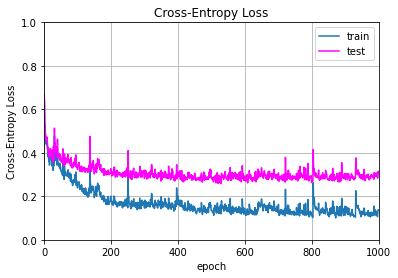

In [11]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['Loss'], eval_dict['Test']['Loss'], 'Cross-Entropy Loss', ylim_top=1)

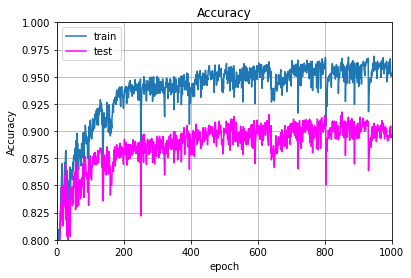

In [12]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['Accuracy'], eval_dict['Test']['Accuracy'], 'Accuracy', ylim_bottom=0.8)

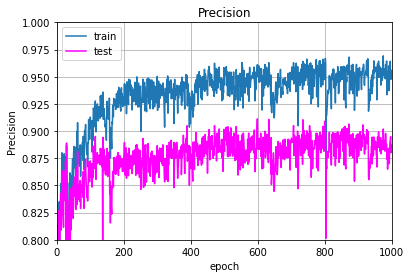

In [13]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['Precision'], eval_dict['Test']['Precision'], 'Precision', ylim_bottom=0.8)

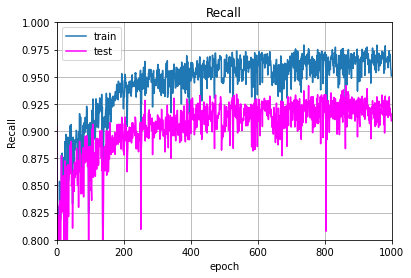

In [14]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['Recall'], eval_dict['Test']['Recall'], 'Recall', ylim_bottom=0.8)

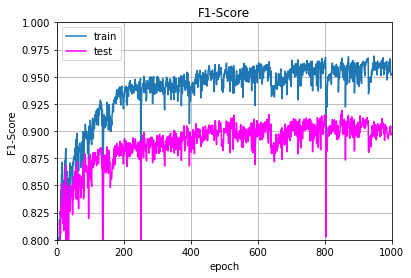

In [15]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['F1-Score'], eval_dict['Test']['F1-Score'], 'F1-Score', ylim_bottom=0.8)

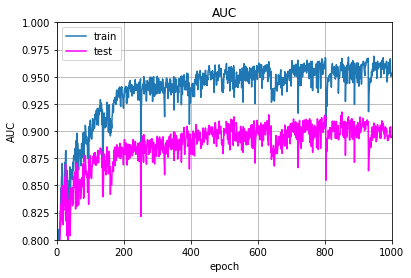

In [16]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['AUC'], eval_dict['Test']['AUC'], 'AUC', ylim_bottom=0.8)

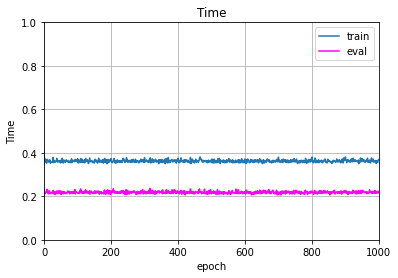

In [17]:
plot(hyperparam_dict['epoch'], eval_dict['Time']['Train_Time'], eval_dict['Time']['Eval_Time'], 'Time', ylim_top=1, legend2='eval')

In [18]:
def find_max(eval_dict):
    for key, value in eval_dict.items():
        if key != 'Time':
            print(key)
            for metric in value:
                if metric not in {'Loss', 'ROC-Curve', 'TP', 'FP', 'TN', 'FN'}:
                    print(metric)
                    print(max(enumerate(np.array(value[metric]).mean(axis=0)), key = lambda x : x[1]))
            print()

find_max(eval_dict)

Train
Accuracy
(947, 0.9688517708343823)
Precision
(975, 0.9691753863860146)
Recall
(738, 0.9792028542517592)
F1-Score
(947, 0.9689949043308559)
AUC
(947, 0.9688367522192994)

Test
Accuracy
(852, 0.9175215331610682)
Precision
(599, 0.9112393513242012)
Recall
(863, 0.9418455330561523)
F1-Score
(852, 0.9189472611653144)
AUC
(852, 0.9175859355788056)



In [19]:
def output(metric, key = 'Test' ,digit = 4):
    for i, x in enumerate(np.array(eval_dict[key][metric]).mean(axis=0)):
        print(f'{i} : {round(x, digit)}')

output('F1-Score')

0 : 0.726
1 : 0.7167
2 : 0.6998
3 : 0.7709
4 : 0.7848
5 : 0.7842
6 : 0.7792
7 : 0.7406
8 : 0.7993
9 : 0.7627
10 : 0.8168
11 : 0.8051
12 : 0.8279
13 : 0.8207
14 : 0.852
15 : 0.8419
16 : 0.8491
17 : 0.8498
18 : 0.8311
19 : 0.8148
20 : 0.8336
21 : 0.8086
22 : 0.818
23 : 0.8303
24 : 0.8592
25 : 0.8368
26 : 0.8686
27 : 0.86
28 : 0.7662
29 : 0.816
30 : 0.8489
31 : 0.7545
32 : 0.8377
33 : 0.8143
34 : 0.831
35 : 0.8004
36 : 0.8334
37 : 0.834
38 : 0.8477
39 : 0.8515
40 : 0.8263
41 : 0.8379
42 : 0.8487
43 : 0.8467
44 : 0.8398
45 : 0.8418
46 : 0.85
47 : 0.8231
48 : 0.8436
49 : 0.837
50 : 0.8582
51 : 0.8474
52 : 0.847
53 : 0.853
54 : 0.8538
55 : 0.8634
56 : 0.8391
57 : 0.8381
58 : 0.8662
59 : 0.8643
60 : 0.8718
61 : 0.8368
62 : 0.864
63 : 0.8536
64 : 0.8497
65 : 0.8286
66 : 0.8509
67 : 0.8558
68 : 0.8598
69 : 0.858
70 : 0.8542
71 : 0.8473
72 : 0.8386
73 : 0.8456
74 : 0.8565
75 : 0.8501
76 : 0.8586
77 : 0.8474
78 : 0.8552
79 : 0.8724
80 : 0.8378
81 : 0.8453
82 : 0.8619
83 : 0.8684
84 : 0.8661
85 : 

0.8838383838383838


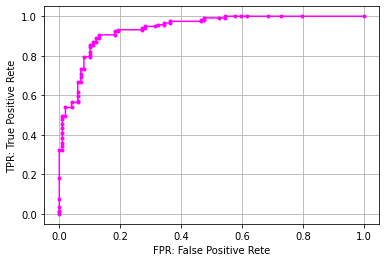

In [20]:
def plot_ROC_Curve(fold, epoch, key = 'Test'):

    fpr, tpr, _ = eval_dict['Test']['ROC-Curve'][fold][epoch]
    print(eval_dict['Test']['AUC'][fold][epoch])
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(fpr, tpr, marker='.',c='#ff00ff')
    ax.set_xlabel('FPR: False Positive Rete')
    ax.set_ylabel('TPR: True Positive Rete')
    # ax.set_aspect('equal')
    ax.grid()

plot_ROC_Curve(7, 213)

# ハイパーパラメータ・評価値の保存

In [21]:
hyperparam_dict['loss_func'] = str(hyperparam_dict['loss_func'])
hyperparam_dict['device'] = str(hyperparam_dict['device'])
hyperparam_dict['optimizer']['algorithm'] = str(hyperparam_dict['optimizer']['algorithm'])

json.dump(hyperparam_dict, open('hyperparameter.json', 'w'), indent=4)
pickle.dump(eval_dict, open('evaluation.pkl', 'wb'))

# 学習・保存の終了時にビープ音で通知

In [22]:
Beep(1100, 1000)